# 05. EDA & Visualization for Top-Down Strategy

---

## 분석 구조

### Group 1: 분포 분석
1. 히스토그램
2. 박스플롯

### Group 2: 관계 분석 
3. 산점도 (Risk-Return)
4. 정규성 검정 (QQ Plot)
5. 상관관계 히트맵

### Group 3: 시계열 패턴 
6. 시계열 분해
7. ADF Test (단위근 검정)
8. ACF / PACF

### Group 4: 섹터/기업 비교
9. Sector Performance Heatmap
10. Top/Bottom Performers
11. Risk-Return Quadrant

---

## 데이터 소스
- `stock_features_clean.csv`: dropna 적용된 Clean 데이터
- 기간: 2020-11-27 ~ 현재 (rolling window 이후)
- 기업 수: 480개

---

## Section 1. 환경 설정 & 데이터 로드

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import os

# 통계 분석
from scipy import stats
from scipy.stats import probplot, normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller

warnings.filterwarnings('ignore')

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# 한글 폰트 설정
import koreanize_matplotlib
pkg_dir = os.path.dirname(koreanize_matplotlib.__file__)
font_path = os.path.join(pkg_dir, 'fonts', 'NanumGothic.ttf')

fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"Font: {font_name}")
print("라이브러리 로드 완료")

Font: NanumGothic
라이브러리 로드 완료


In [2]:
# 경로 설정
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'Data_set'
VIZ_DIR = DATA_DIR / 'Visualizations'
TABLEAU_DIR = DATA_DIR / 'Tableau_Csv'

VIZ_DIR.mkdir(exist_ok=True)
TABLEAU_DIR.mkdir(exist_ok=True)

print(f"프로젝트 경로: {PROJECT_ROOT}")
print(f"시각화 저장: {VIZ_DIR}")

프로젝트 경로: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance
시각화 저장: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance/Data_set/Visualizations


In [3]:
# 데이터 로드 (Clean 데이터 사용)
print("=" * 60)
print("데이터 로드")
print("=" * 60)

df = pd.read_csv(DATA_DIR / 'stock_features_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"\n로드 완료")
print(f"  Shape: {df.shape}")
print(f"  기간: {df['Date'].min().date()} ~ {df['Date'].max().date()}")
print(f"  기업 수: {df['Company'].nunique()}")
print(f"\n컬럼 ({len(df.columns)}개):")
print(df.columns.tolist())

데이터 로드



로드 완료
  Shape: (603359, 41)
  기간: 2020-11-27 ~ 2026-01-09
  기업 수: 481

컬럼 (41개):
['Date', 'Company', 'Sector', 'Industry', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return_raw', 'Daily_Return_calc', 'Cum_Return', 'Return_1M', 'Return_3M', 'Return_6M', 'MA_5', 'MA_20', 'MA_60', 'Volatility_20d', 'Drawdown', 'MDD', 'DD_Short', 'Vol_MA_20', 'Vol_Ratio', 'Vol_Std_20', 'Vol_Z_Score', 'Log_Volume', 'Log_Volume_W', 'RSI_14', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'Dividends', 'Stock Splits', 'Daily_Return', 'Cum_Max', 'Prev_Close', 'Gap', 'Gap_Pct', 'Is_Extreme_Change']


---

## Section 2. Group 1 - 분포 분석

### 2.1 히스토그램

**분석 대상 변수:**
- `Daily_Return_raw`: 일간 수익률
- `Volatility_20d`: 20일 변동성 (연환산)
- `RSI_14`: RSI 지표
- `Vol_Ratio`: 거래량 비율
- `MDD`: 최대 낙폭
- `Return_1M`: 1개월 모멘텀

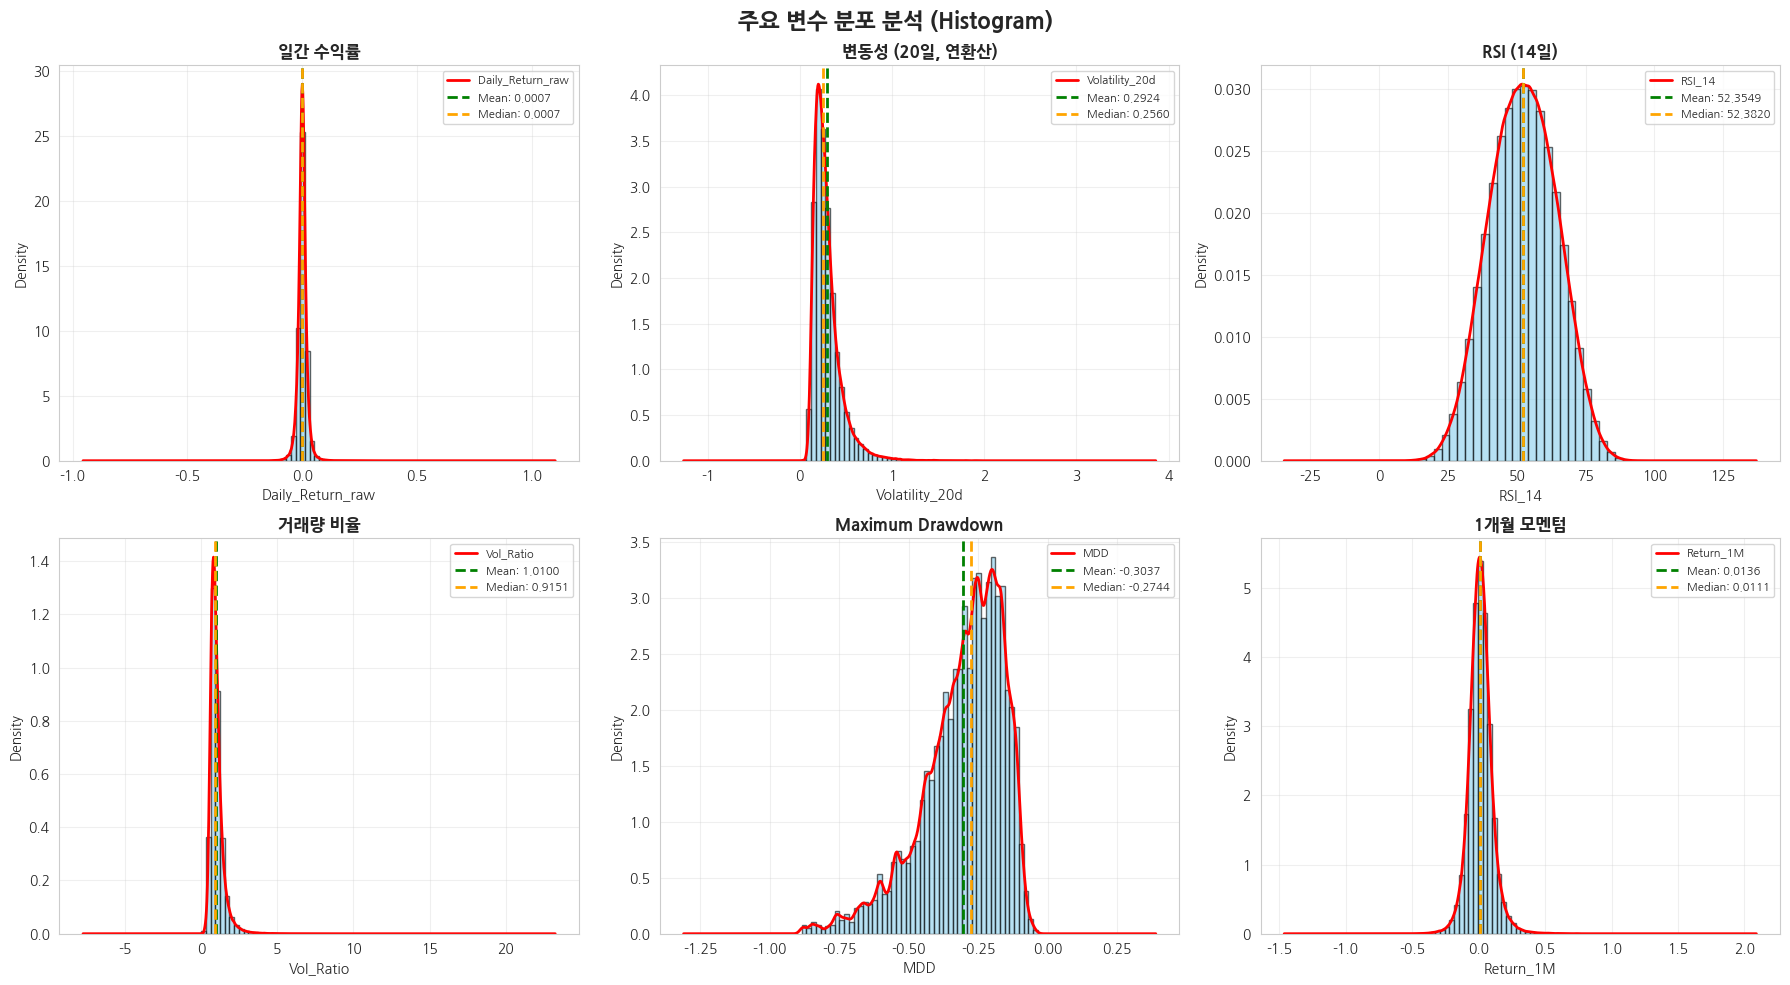

In [4]:
# 주요 변수 히스토그램
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('주요 변수 분포 분석 (Histogram)', fontsize=16, fontweight='bold')

variables = [
    ('Daily_Return_raw', '일간 수익률', 50),
    ('Volatility_20d', '변동성 (20일, 연환산)', 50),
    ('RSI_14', 'RSI (14일)', 30),
    ('Vol_Ratio', '거래량 비율', 50),
    ('MDD', 'Maximum Drawdown', 50),
    ('Return_1M', '1개월 모멘텀', 50)
]

for idx, (col, title, bins) in enumerate(variables):
    ax = axes[idx // 3, idx % 3]
    
    if col not in df.columns:
        ax.text(0.5, 0.5, f'{col} 없음', ha='center', va='center')
        continue
    
    data = df[col].dropna()
    
    ax.hist(data, bins=bins, alpha=0.6, color='skyblue', edgecolor='black', density=True)
    data.plot(kind='kde', ax=ax, color='red', linewidth=2)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    
    mean, median = data.mean(), data.median()
    ax.axvline(mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean:.4f}')
    ax.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.4f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(VIZ_DIR / '01_histogram.png', dpi=300, bbox_inches='tight')
plt.show()


### 1. 일간 수익률

* **분포 특성:** 전형적인 **고첨도** 분포. 중심(0.0) 밀집 및 얇고 긴 꼬리 확인.
* **통계량:** 평균(0.0007)과 중앙값(0.0007) 일치, 중심 경향성 0 수렴.
* **시사점:** 주가 변동 미미하나 간헐적 극단적 변동(Fat-tail) 존재. 정규분포 가정 모델링 시 주의 요망.

### 2. 변동성 (Volatility_20d, 연환산)

* **분포 특성:** 강한 **우편향(Right-Skewed)** 분포. 대다수 연환산 변동성 20~40% 구간 위치.
* **이상치:** 1.0(100%) 이상 초고변동성 종목의 긴 꼬리 형성.
* **시사점:** 데이터 스케일 격차 확인. 로그 변환 또는 Robust Scaling 등 전처리 필요.

### 3. RSI (14일)

* **분포 특성:** **정규분포(Gaussian Distribution)** 근사.
* **통계량:** 평균(52.36) 및 중앙값(52.39) 50 근접, 좌우 대칭 유지.
* **시사점:** 기술적 지표 신뢰도 확보. 과매수(70)/과매도(30) 임계값의 통계적 유효성 확인.

### 4. 거래량 비율 (Vol_Ratio)

* **분포 특성:** 극단적 **우편향(Right-Skewed)** 확인. 평균(1.0) 밀집 및 우측 긴 꼬리 발생.
* **이상치:** 평소 대비 5~10배 이상 거래량 폭증 이벤트(Earnings Surprise 등) 존재.
* **시사점:** 원본 사용 시 과대적합 위험 상존. `Log1p` 변환 및 `Winsorizing` 적용 필수성 입증.

### 5. Maximum Drawdown (MDD)

* **분포 특성:** **좌편향(Left-Skewed)** 분포. 0(고점)에서 -1.0 방향 꼬리 형성.
* **통계량:** 평균 낙폭 약 -30%(-0.30) 기록.
* **시사점:** -0.2 ~ -0.4 구간 집중. -0.8 이하 극단적 손실 구간 종목은 '소외주' 또는 '한계기업' 분류 및 리스크 필터링 활용 가능.

### 6. 1개월 모멘텀 (Return_1M)

* **분포 특성:** 0 중심 대칭적 종 모양 형성, 일간 수익률 대비 큰 분산 확인.
* **시사점:** 단기 추세 강도 지표 적합. 정규분포 근사로 별도 변환 없이 모델 피처 활용 가능.

---

### 종합 결론 및 Action Item

1. **데이터 정규성:** RSI, 1개월 모멘텀 제외 변수들의 비정규성 확인.
2. **이상치 제어:** `Vol_Ratio`, `Volatility_20d`(우측), `MDD`(좌측) 꼬리 극단값의 모델링 방해 가능성 인지.
3. **전처리 전략 확정:**
* **거래량/변동성:** `Log` 변환 및 `Winsorizing` 유지.
* **수익률/모멘텀:** `StandardScaler` 또는 `RobustScaler` 적용 검토.
* **RSI:** 별도 변환 없이 사용 가능 (MinMax Scaling 고려).

### 2.2 박스플롯 (섹터별)

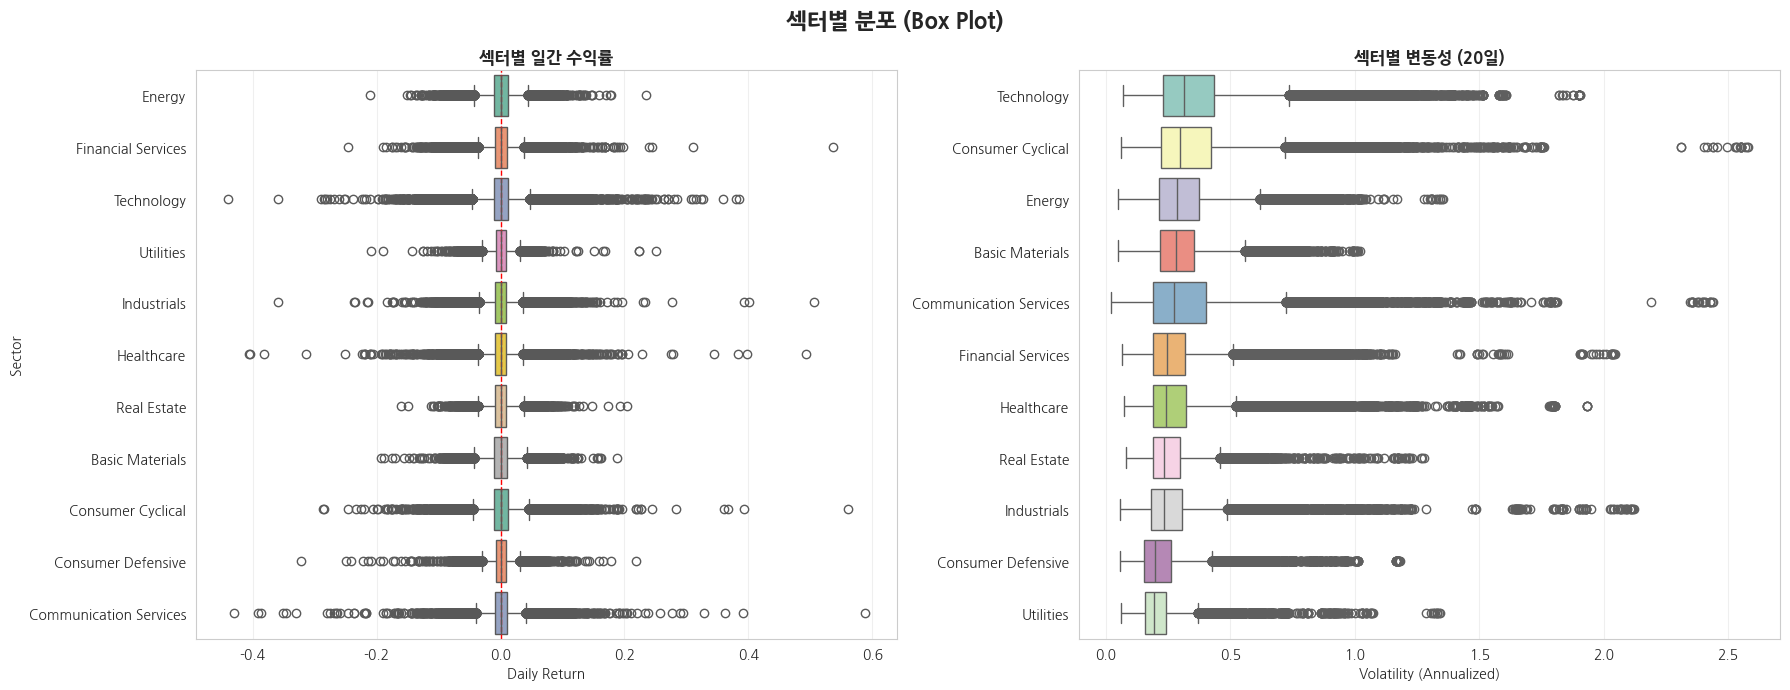

In [5]:
# 섹터별 수익률 분포
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('섹터별 분포 (Box Plot)', fontsize=16, fontweight='bold')

# 1. Daily Return
df_box = df[df['Daily_Return_raw'].notna()].copy()
sector_order = df_box.groupby('Sector')['Daily_Return_raw'].median().sort_values(ascending=False).index

sns.boxplot(data=df_box, y='Sector', x='Daily_Return_raw', order=sector_order, ax=axes[0], palette='Set2')
axes[0].set_title('섹터별 일간 수익률', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Daily Return')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Volatility
df_vol = df[df['Volatility_20d'].notna()].copy()
sector_order_vol = df_vol.groupby('Sector')['Volatility_20d'].median().sort_values(ascending=False).index

sns.boxplot(data=df_vol, y='Sector', x='Volatility_20d', order=sector_order_vol, ax=axes[1], palette='Set3')
axes[1].set_title('섹터별 변동성 (20일)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Volatility (Annualized)')
axes[1].set_ylabel('')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(VIZ_DIR / '02_boxplot_sector.png', dpi=300, bbox_inches='tight')
plt.show()

#### **섹터별 일간 수익률**

* **중심 경향성**: 대다수 섹터의 일간 수익률 중앙값은 0에 수렴함. 효율적 시장 가설에 부합하는 정규분포 형태를 보임.
* **변동폭**:
* **Technology(기술)** 및 **Consumer Cyclical(임의소비재)**: Box의 너비와 위아래 수염이 길게 형성됨. 시장 민감도가 높고 등락폭이 큼을 의미.
* **Utilities(유틸리티)** 및 **Consumer Defensive(필수소비재)**: 상대적으로 Box가 좁고 이상치 범위가 제한적임. 방어적 성격 확인.


* **이상치**: 전 섹터에 걸쳐 0.2(20%) 이상의 극단적 수익률 발생 빈도가 관측됨. 이는 시장 충격 시기의 데이터로 추정.

#### **섹터별 변동성**

* **리스크 레벨**:
* **High Volatility**: Technology, Consumer Cyclical 섹터가 가장 높은 중앙값을 기록. 공격적 투자 성향의 군집 형성 예상.
* **Low Volatility**: Utilities, Consumer Defensive, Industrials 섹터가 하위권에 위치. 안정형 자산으로서의 특징 뚜렷.


**특이사항**:
* **Energy(에너지)**: Box 자체(IQR)는 좁으나, 우측으로 긴 꼬리 형태의 이상치가 다수 존재. 유가 급등락 등 거시경제 이벤트에 민감하게 반응하는 특성이 반영됨.

---

## Section 3. Group 2 - 관계 분석

### 3.1 Risk-Return 산점도

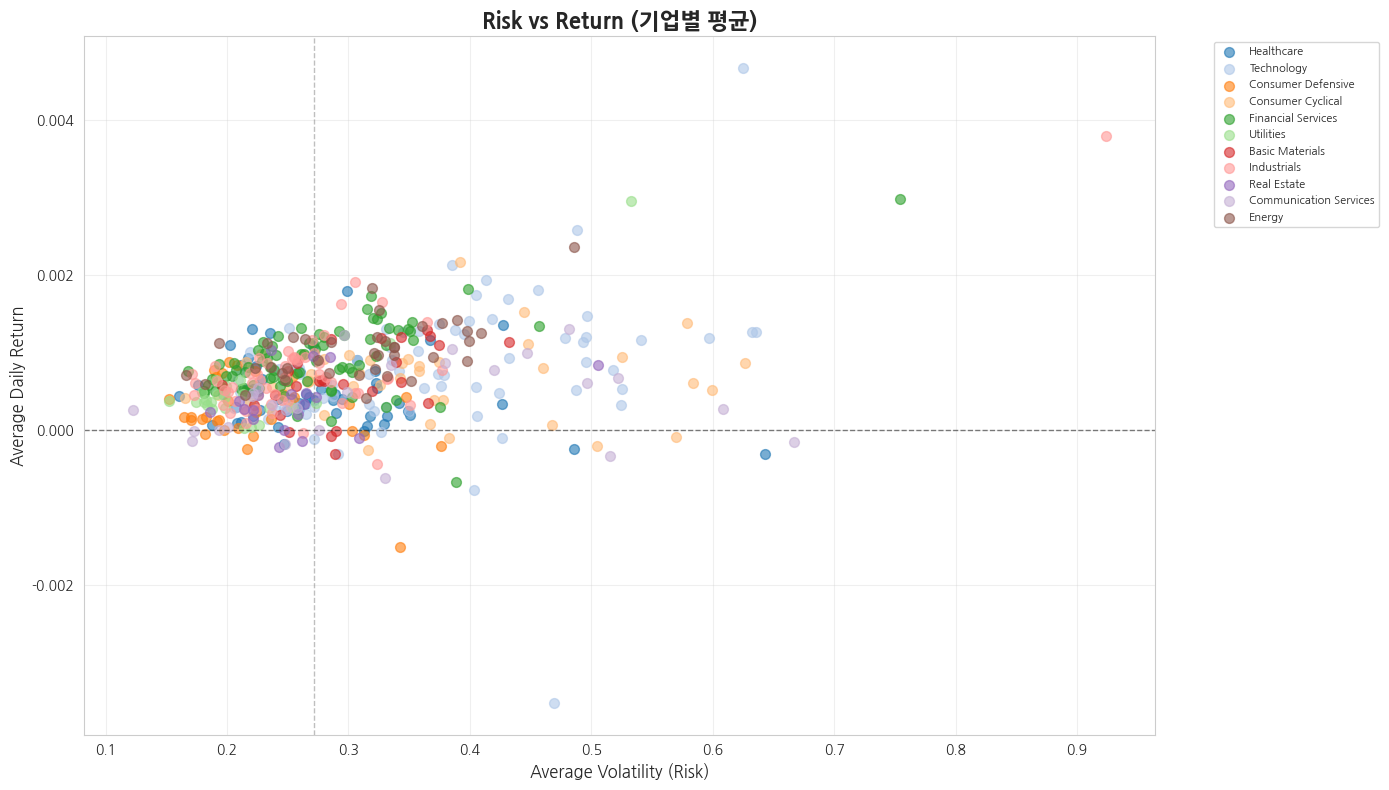

In [6]:
# 기업별 평균 수익률 vs 변동성
company_stats = df.groupby('Company').agg({
    'Daily_Return_raw': 'mean',
    'Volatility_20d': 'mean',
    'Sector': 'first'
}).reset_index()

company_stats.columns = ['Company', 'Avg_Return', 'Avg_Volatility', 'Sector']
company_stats = company_stats.dropna()

# 산점도
plt.figure(figsize=(14, 8))
sectors = company_stats['Sector'].unique()
colors = sns.color_palette('tab20', len(sectors))

for sector, color in zip(sectors, colors):
    sector_data = company_stats[company_stats['Sector'] == sector]
    plt.scatter(sector_data['Avg_Volatility'], sector_data['Avg_Return'], 
                label=sector, alpha=0.6, s=50, color=color)

plt.title('Risk vs Return (기업별 평균)', fontsize=16, fontweight='bold')
plt.xlabel('Average Volatility (Risk)', fontsize=12)
plt.ylabel('Average Daily Return', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(company_stats['Avg_Volatility'].median(), color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(VIZ_DIR / '03_scatter_risk_return.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Tableau용 저장
company_stats.to_csv(TABLEAU_DIR / 'risk_return_scatter.csv', index=False)

### 3.2 정규성 검정 (QQ Plot)

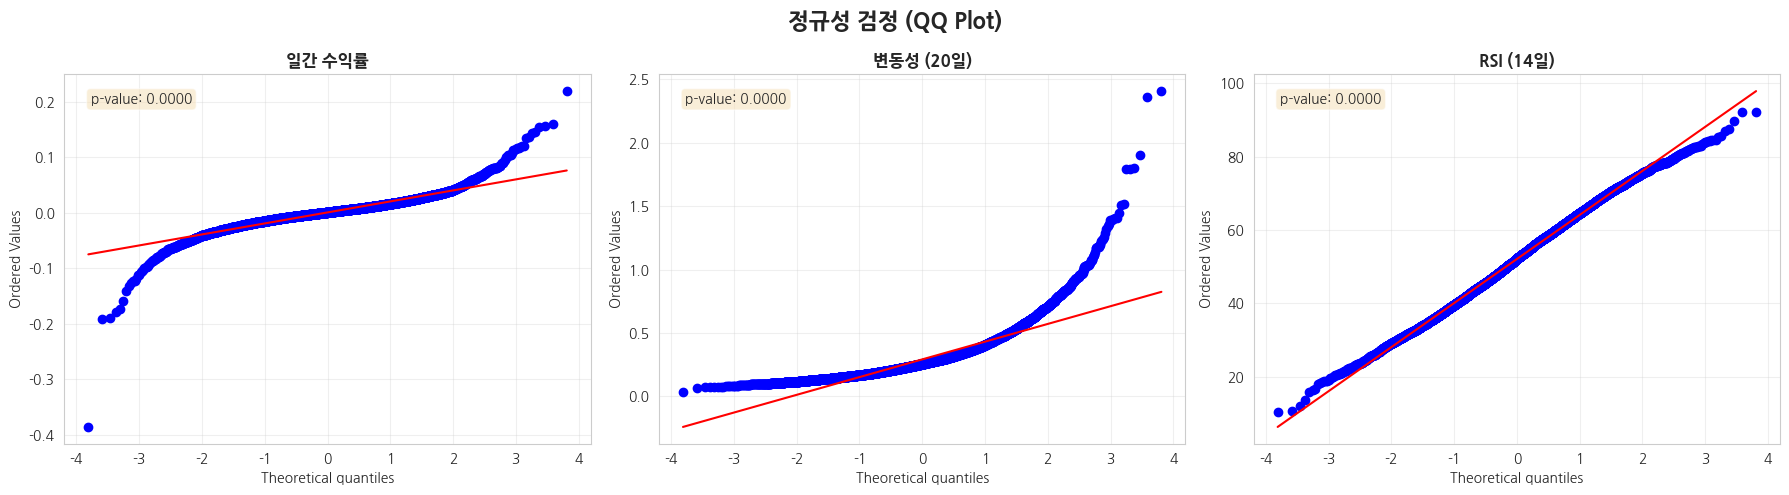

In [8]:
# QQ Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('정규성 검정 (QQ Plot)', fontsize=16, fontweight='bold')

variables_qq = [
    ('Daily_Return_raw', '일간 수익률'),
    ('Volatility_20d', '변동성 (20일)'),
    ('RSI_14', 'RSI (14일)')
]

qq_data_list = []

for idx, (col, title) in enumerate(variables_qq):
    ax = axes[idx]
    data = df[col].dropna().sample(min(10000, len(df[col].dropna())))
    
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    stat, p_value = normaltest(data)
    ax.text(0.05, 0.95, f'p-value: {p_value:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(VIZ_DIR / '04_qqplot.png', dpi=300, bbox_inches='tight')
plt.show()

#### **A. 일간 수익률 (Daily Return)**

* **분포 형태**: 중앙부는 적색선에 근접하나, 양쪽 꼬리(Tails) 부분이 대각선에서 벗어나는 **'Fat-tail'** 형태 관측.
* **해석**: 전형적인 금융 시계열 데이터의 특성. 정규분포 모델이 예측하는 것보다 극단적인 상승/하락이 더 빈번하게 발생함.
* **통계 검정**: P-value 0.0000으로 유의수준 0.05 하에서 귀무가설(: 정규분포를 따른다) 기각.

#### **B. 변동성 (Volatility, 20일)**

* **분포 형태**: 데이터가 위쪽으로 휘어지는 **강한 우측 편포** 형태.
* **해석**: 변동성은 음수가 될 수 없고(0 하한), 시장 공포 구간에서 수치가 급격히 치솟는 특성이 반영됨. 정규분포와 거리가 가장 멂.
* **통계 검정**: P-value 0.0000으로 정규성 기각.

#### **C. RSI (14일)**

* **분포 형태**: 세 변수 중 적색선에 가장 근접하여 **상대적으로 정규분포와 유사**한 패턴을 보임.
* **해석**: 오실레이터 지표 특성상 값이 0과 100 사이로 제한되므로 양 끝단에서 미세한 이탈 발생. 중간 영역 데이터는 안정적임.
* **통계 검정**: P-value 0.0000으로 통계적으로는 정규성 기각(대규모 데이터 샘플 특성상 p-value가 낮게 나오는 경향 존재).

### **3. 모델링 전략**

* **스케일링 선정**:
* **MinMaxScaler/StandardScaler 지양**: `Daily Return`과 `Volatility`의 이상치 및 편포로 인해 왜곡 발생 가능성 높음.
* **RobustScaler 적용**: 사분위수(IQR)를 사용하여 이상치의 영향을 최소화하는 스케일링 방식 채택 권장.


* **변수 변환**:
* **Log 변환**: 우측으로 치우친 `Volatility` 변수에 `np.log1p`를 적용하여 정규분포에 가깝게 보정 필요.


* **모델링 고려사항**:
* 선형 회귀 등 정규성 가정이 엄격한 모델보다는, 트리 기반 모델(Random Forest, XGBoost) 등 **비모수적 방법론**이 더 적합할 것으로 판단.

### 3.3 상관관계 히트맵

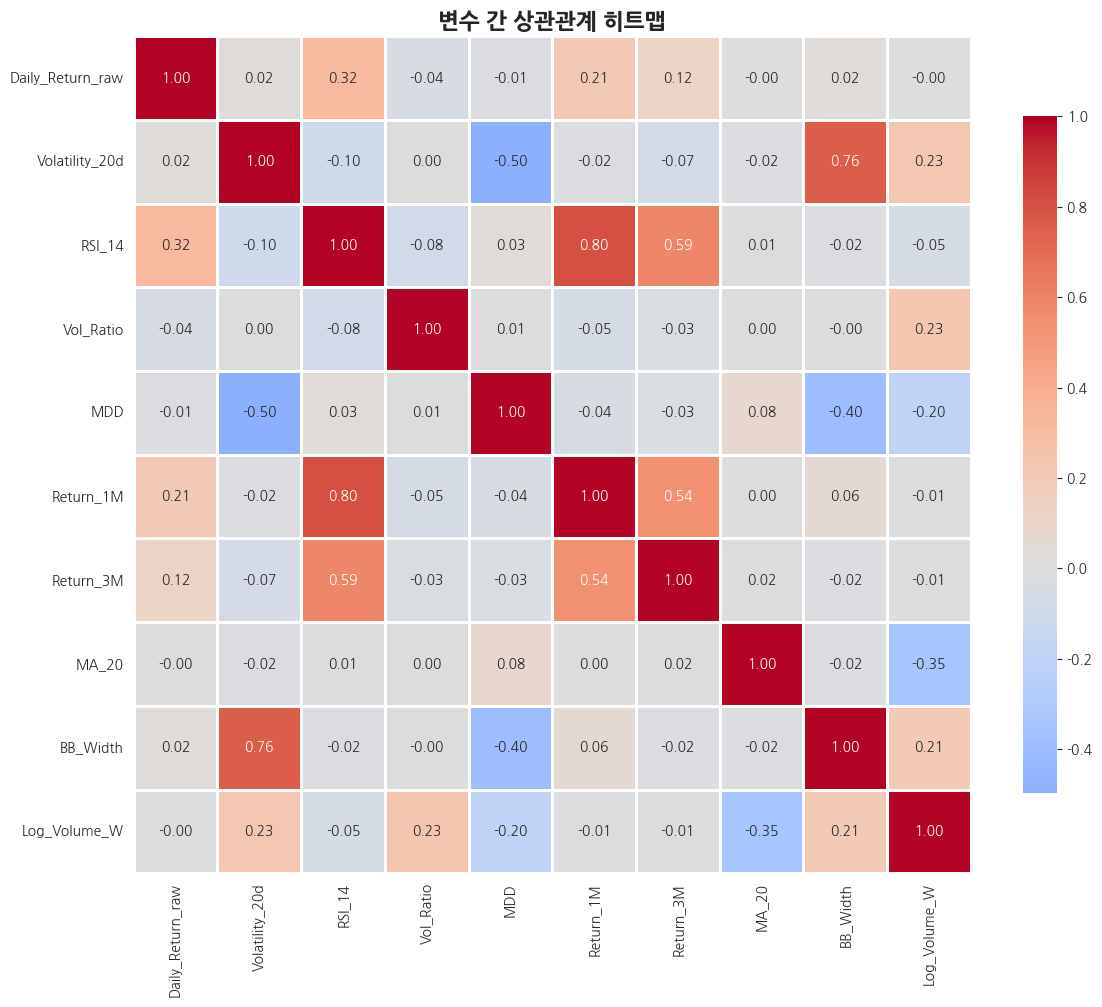

In [9]:
# 상관관계 분석
corr_vars = [
    'Daily_Return_raw', 'Volatility_20d', 'RSI_14', 'Vol_Ratio', 
    'MDD', 'Return_1M', 'Return_3M', 'MA_20', 'BB_Width', 'Log_Volume_W'
]

# 존재하는 컬럼만 선택
corr_vars = [col for col in corr_vars if col in df.columns]

df_corr = df[corr_vars].dropna()
correlation_matrix = df_corr.corr()

# 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('변수 간 상관관계 히트맵', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / '05_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Tableau용 저장
corr_stacked = correlation_matrix.stack().reset_index()
corr_stacked.columns = ['Variable_1', 'Variable_2', 'Correlation']
corr_stacked.to_csv(TABLEAU_DIR / 'correlation_matrix.csv', index=False)

#### **주요 상관관계 그룹**

1. **모멘텀 지표 간 강한 동조화**
* **`RSI_14` <-> `Return_1M`**: 단기 모멘텀 성격이 겹침. 모델링 시 둘 중 하나만 선택하거나 PCA 등을 통한 차원 축소 권장.
* `Return_1M` <-> `Return_3M`: 추세 지속성 확인.


2. **변동성 지표 간 중복성**
* **`Volatility_20d` <-> `BB_Width`**: 볼린저 밴드 폭이 변동성을 기반으로 산출되므로 정보가 중복됨. `BB_Width` 제거 고려.


3. **수익률과 변동성의 관계**
* `Volatility_20d` <-> `MDD`: 변동성이 클수록 낙폭(MDD)도 깊어지는 역의 상관관계(MDD가 음수이므로 실제 위험도는 양의 상관) 확인.


4. **독립 변수 특성**
* **`Daily_Return_raw`**: 타 파생변수들과의 상관계수가 대부분  수준으로 낮음. 예측 모델의 Target 또는 독립적 피처로 활용 가능성 높음.



### **3. 전처리 및 피처 엔지니어링 전략**

* **변수 선택**:
* 다중공선성 우려가 있는 `RSI_14`와 `Return_1M` 중 설명력이 높은 변수 택일.
* `BB_Width`는 `Volatility_20d`와 정보량이 중복되므로 모델 복잡도 감소를 위해 제거 검토.


* **스케일링**:
* **Volatility**: 편포 해소를 위해 `np.log1p` 적용 후 Standardization 수행.
* **Return/RSI**: 이상치 영향을 제어하기 위해 RobustScaler 적용.

---

## Section 4. Group 3 - 시계열 패턴

### 4.1 시계열 분해

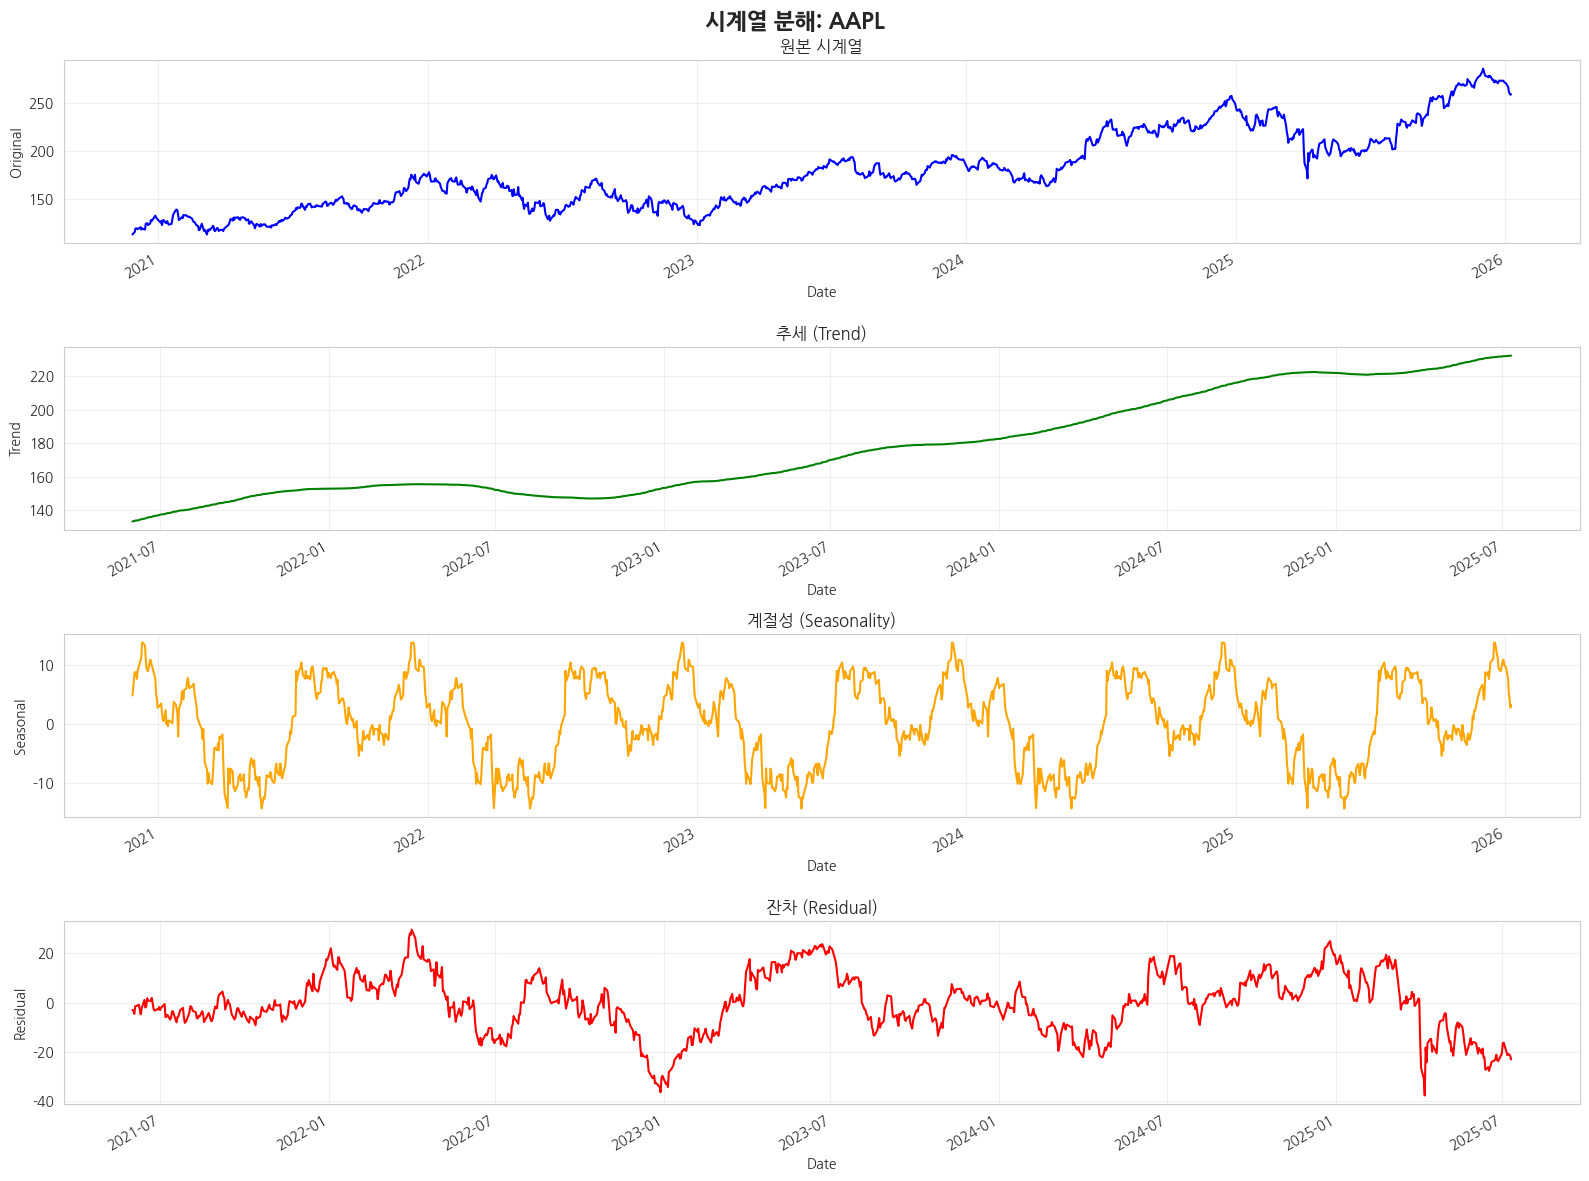

In [10]:
# 대표 기업 선택 (AAPL)
sample_ticker = 'AAPL'
df_ts = df[df['Company'] == sample_ticker].copy()
df_ts = df_ts.set_index('Date').sort_index()

# 시계열 분해
decomposition = seasonal_decompose(df_ts['Close'], model='additive', period=252)

# 시각화
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle(f'시계열 분해: {sample_ticker}', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Original')
axes[0].set_title('원본 시계열')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='green')
axes[1].set_ylabel('Trend')
axes[1].set_title('추세 (Trend)')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='orange')
axes[2].set_ylabel('Seasonal')
axes[2].set_title('계절성 (Seasonality)')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='red')
axes[3].set_ylabel('Residual')
axes[3].set_title('잔차 (Residual)')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / f'06_decomposition_{sample_ticker}.png', dpi=300, bbox_inches='tight')
plt.show()

# Tableau용 저장
decomp_df = pd.DataFrame({
    'Date': decomposition.observed.index,
    'Original': decomposition.observed.values,
    'Trend': decomposition.trend.values,
    'Seasonal': decomposition.seasonal.values,
    'Residual': decomposition.resid.values,
    'Company': sample_ticker
})
decomp_df.to_csv(TABLEAU_DIR / f'decomposition_{sample_ticker}.csv', index=False)

### 4.2 ADF Test (단위근 검정)

In [11]:
# ADF Test (전체 종목)
adf_results = []
tickers = df['Company'].unique()

for ticker in tickers:
    series = df[df['Company'] == ticker]['Close'].dropna()
    if len(series) < 100:
        continue
    
    result = adfuller(series)
    p_value = result[1]
    has_trend = p_value > 0.05
    
    adf_results.append({
        'Company': ticker,
        'p_value': p_value,
        'Has_Trend': has_trend
    })

adf_df = pd.DataFrame(adf_results)

trend_count = adf_df['Has_Trend'].sum()
print("=" * 50)
print(f"ADF Test 결과:")
print(f"- 전체 종목 수: {len(adf_df)}")
print(f"- 추세가 있는 종목 (비정상): {trend_count}개 ({trend_count/len(adf_df)*100:.1f}%)")
print(f"- 추세가 없는 종목 (정상): {len(adf_df) - trend_count}개")
print("=" * 50)

ADF Test 결과:
- 전체 종목 수: 480
- 추세가 있는 종목 (비정상): 446개 (92.9%)
- 추세가 없는 종목 (정상): 34개


### 4.3 ACF / PACF

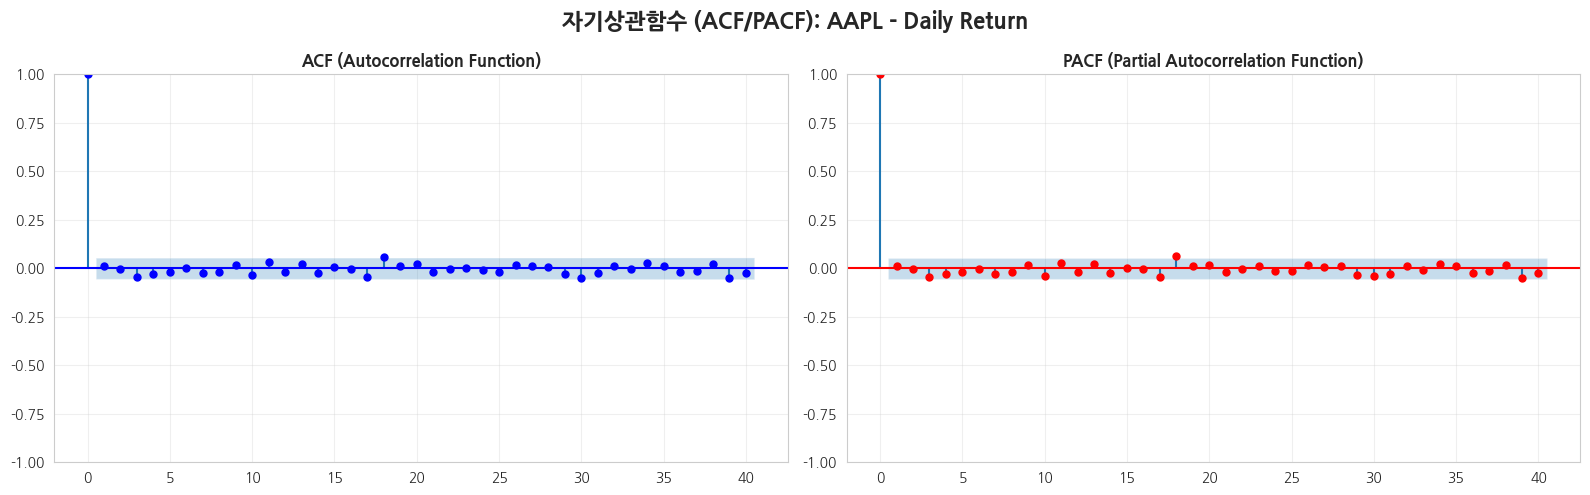

In [12]:
# ACF / PACF
sample_ticker = 'AAPL'
df_ts = df[df['Company'] == sample_ticker].copy()
df_ts = df_ts.set_index('Date').sort_index()

returns = df_ts['Daily_Return_raw'].dropna()
lags = 40

# ACF/PACF 계산
acf_values = acf(returns, nlags=lags, fft=True)
pacf_values = pacf(returns, nlags=lags, method='ywm')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f'자기상관함수 (ACF/PACF): {sample_ticker} - Daily Return', fontsize=16, fontweight='bold')

plot_acf(returns, lags=lags, ax=axes[0], color='blue')
axes[0].set_title('ACF (Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

plot_pacf(returns, lags=lags, ax=axes[1], color='red', method='ywm')
axes[1].set_title('PACF (Partial Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / f'07_acf_pacf_Daily_Return_{sample_ticker}.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Tableau용 저장
acf_df = pd.DataFrame({
    'Lag': range(len(acf_values)),
    'ACF': acf_values,
    'PACF': pacf_values,
    'Company': sample_ticker
})
acf_df.to_csv(TABLEAU_DIR / f'acf_pacf_Daily_Return_{sample_ticker}.csv', index=False)

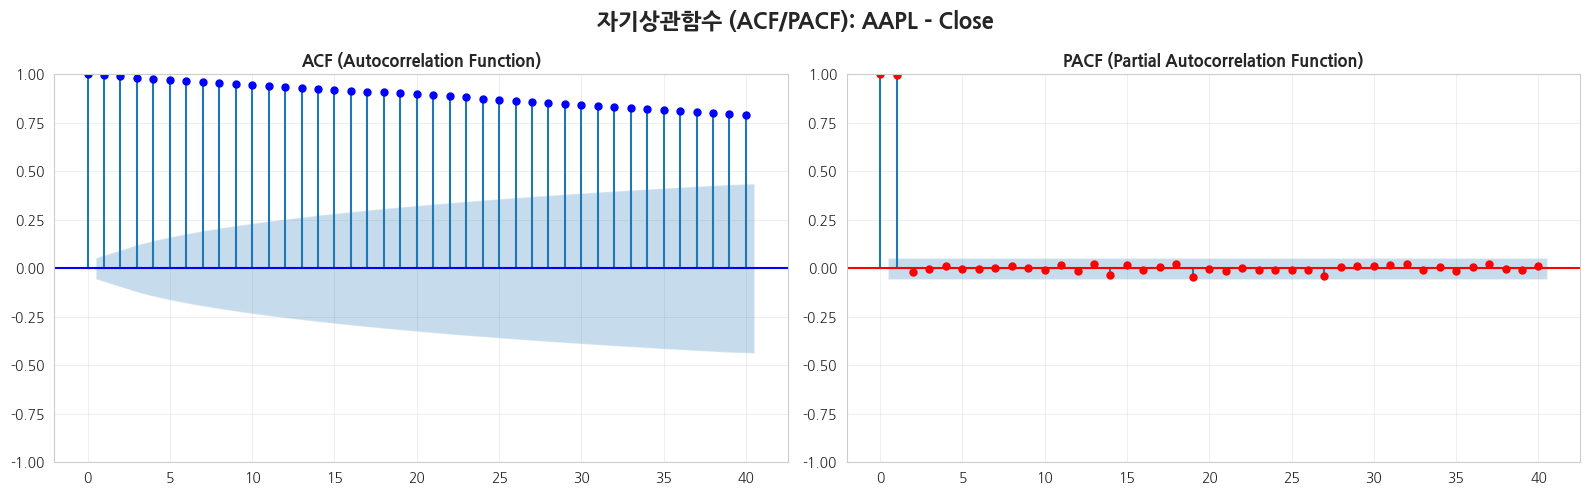

In [14]:
# ACF / PACF
sample_ticker = 'AAPL'
df_ts = df[df['Company'] == sample_ticker].copy()
df_ts = df_ts.set_index('Date').sort_index()

returns = df_ts['Close'].dropna()
lags = 40

# ACF/PACF 계산
acf_values = acf(returns, nlags=lags, fft=True)
pacf_values = pacf(returns, nlags=lags, method='ywm')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f'자기상관함수 (ACF/PACF): {sample_ticker} - Close', fontsize=16, fontweight='bold')

plot_acf(returns, lags=lags, ax=axes[0], color='blue')
axes[0].set_title('ACF (Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

plot_pacf(returns, lags=lags, ax=axes[1], color='red', method='ywm')
axes[1].set_title('PACF (Partial Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / f'07_acf_pacf_Close_{sample_ticker}.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Tableau용 저장
acf_df = pd.DataFrame({
    'Lag': range(len(acf_values)),
    'ACF': acf_values,
    'PACF': pacf_values,
    'Company': sample_ticker
})
acf_df.to_csv(TABLEAU_DIR / f'acf_pacf_Close_{sample_ticker}.csv', index=False)

### **1. 진단 개요**

* **목적**: 자기상관 구조 파악을 통한 시계열 모형 적합성 판단.
* **대상**: AAPL **종가(Close)** 원본 데이터 vs 1차 차분된 **일간 수익률(Daily Return)**.
* **도구**: ACF(자기상관함수) 및 PACF(편자기상관함수) 시각화.

### **2. 그래프별 상세 해석**

#### **A. 종가 (Close) - 비정상 시계열**

* **ACF**:
* 시차(Lag)가 증가함에 따라 상관계수가 매우 천천히 선형적으로 감소함.
* 전형적인 **비정상(Non-stationary)** 데이터의 특징인 '기억' 효과 존재.


* **PACF**:
* 시차 1에서 상관계수 1.0에 근접한 강한 스파이크 발생 후 급격히 절단(Cut-off).


* **진단 결과**:
* 데이터에 **단위근** 존재 확인.
* 전일 가격이 당일 가격을 거의 100% 설명하는 **랜덤 워크** 패턴.
* 평균과 분산이 일정하지 않아 시계열 예측 모델 직접 적용 불가.



#### **B. 일간 수익률 (Daily Return) - 정상 시계열**

* **ACF**:
* 시차 0(자기 자신)을 제외한 모든 시차에서 값이 **95% 신뢰구간(푸른 영역)** 내에 위치.
* 과거의 수익률과 현재 수익률 간의 선형적 상관관계가 소멸됨.


* **PACF**:
* 특정한 패턴 없이 0을 중심으로 무작위 분포.


* **진단 결과**:
* **정상성** 확보 완료.
* **백색 잡음** 과정에 근사하며 약형 효율적 시장 가설에 부합.
* 별도의 추가 차분 과정 불필요.



### **3. 모델링 적용 전략**

#### **Prophet 적용 시 강점**

* **이상치 처리**: `Box Plot` 및 `QQ Plot`에서 확인된 다수의 이상치를 별도 제거 없이 모델 내에서 소화하거나 변화점으로 인식 가능.
* **추세 추출**: 프로젝트 핵심 목표인 **'섹터 로테이션(주도 섹터 식별)'** 은 일일 등락 예측보다 **거시적인 상승/하락 국면** 파악이 우선임.
* **유연성**: 주식 시장 특유의 캘린더 효과(월말/월초 효과 등)를 계절성 성분으로 반영하기 용이.

#### **Main Model: Prophet**
* **선정 사유**: 시계열의 자기상관성이 낮은 주가 데이터 특성상, 패턴 매칭보다는 **국면 파악**에 유리한 Prophet이 적합.
* **활용**: 섹터 지수의 향후 30일 **추세선** 및 **신뢰구간** 산출에 활용.


* **Sub Model: GARCH (참고)**
* **보완**: 수익률 자체의 예측(ARIMA)보다는, `Volatility Clustering`(변동성 군집) 현상을 포착하여 **리스크(변동성) 예측**에 특화된 GARCH 모델 병행 고려.
* **목적**: Prophet으로 방향성을 잡고, GARCH로 진입 시점의 위험도를 헷징하는 전략 권장.

---

**자기상관**
* **의미**: 과거의 내가 현재의 나에게 미치는 영향력.
* **비유**: "어제 주가가 올랐으니 오늘 주가도 오를까?"를 수치로 확인하는 것.


**ACF (전체 영향력)**
* **의미**: 중간 과정을 포함한 모든 과거의 영향력 합계.
* **비유**: 나비효과. 3일 전의 상승이 2일 전, 1일 전을 거쳐 오늘에게 준 **모든 영향**.


**PACF (직접 영향력)**
* **의미**: 중간 과정을 싹 무시하고, 딱 그 시점의 데이터가 미친 순수한 영향력.
* **비유**: 3일 전의 뉴스가 오늘 주가에 **다이렉트로** 미친 영향.

---

**정상성**
* **의미**: 데이터의 평균이나 변동 폭이 일정해서 예측하기 쉬운 상태.
* **비유**: **'잔잔한 호수'**. 물결(수익률)은 치지만 수면의 높이(평균 0)는 일정함. 통계 모델은 이런 상태를 좋아함.


**비정상성**
* **의미**: 시간이 갈수록 값이 계속 커지거나 작아져서 평균을 종잡을 수 없는 상태.
* **비유**: **'등산로'**. 시간이 지날수록 고도(주가)가 계속 변함. 예측이 매우 어려움.


**단위근**
* **의미**: 데이터가 비정상성(예측 불가능)을 띠게 만드는 근본적인 원인.
* **판단**: "단위근이 있다" = "데이터가 불안정하다" = "그냥 쓰면 분석 망한다".


**랜덤 워크**
* **의미**: 술 취한 사람의 걸음걸이. 다음에 어디로 발을 딛을지 확률적으로만 알 수 있고 패턴이 없음.
* **결론**: "주가는 랜덤 워크다" = "내일 오를지 내릴지 과거 차트만 봐선 절대 모른다".


**백색 잡음**
* **의미**: 아무런 패턴이 없는 무작위 신호. TV 치직거리는 소리.
* **해석**: 분석 결과가 백색 잡음이 나왔다면, "더 이상 찾아낼 규칙이 없다(이미 다 찾았거나, 원래 없거나)"는 뜻.



---

**ARIMA**
* **특징**: "어제의 가격 패턴이 오늘도 반복되겠지?"라고 가정하는 수학 모범생 같은 모델.
* **한계**: 주식처럼 제멋대로인(랜덤 워크) 데이터 앞에서는 예측을 포기(0으로 수렴)해버림.


**Prophet**
* **특징**: 페이스북이 만든 모델. 수학적 규칙보다는 **"눈에 보이는 추세"** 를 잘 그림.
* **장점**: "크리스마스엔 쇼핑주가 오르지", "전체적으로 우상향이네" 같은 직관적인 흐름을 잘 잡아냄. 주식의 큰 흐름(섹터 로테이션) 볼 때 유리함.


**GARCH**
* **특징**: 가격이 '얼마'일지는 못 맞추지만, **'얼마나 미친 듯이 흔들릴지(변동성)'** 를 맞추는 모델.
* **용도**: "내일 폭락할 거야"가 아니라, "내일 시장이 엄청 불안할 거야(위험해)"를 경고해줌.

---

## Section 5. Group 4 - 섹터/기업 비교

### 5.1 섹터 성과 히트맵

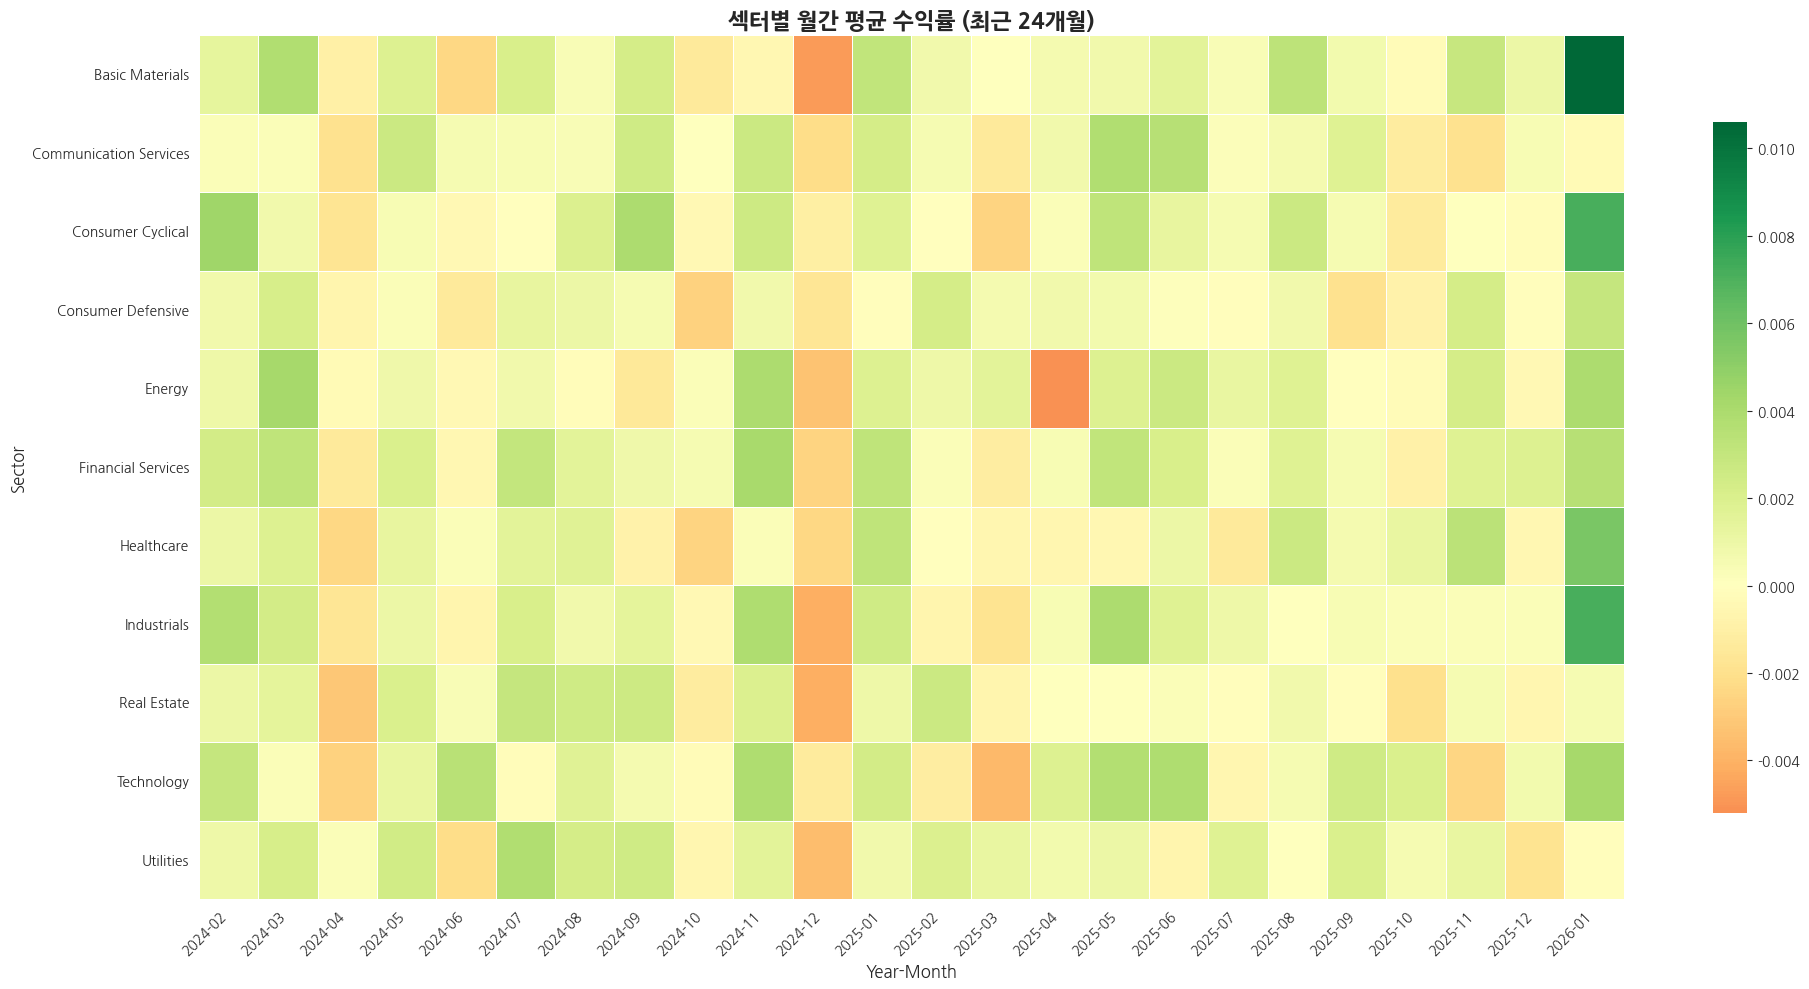

In [16]:
# 월별 섹터 성과
df['Year_Month'] = df['Date'].dt.to_period('M')
sector_monthly = df.groupby(['Year_Month', 'Sector'])['Daily_Return_raw'].mean().reset_index()
sector_pivot = sector_monthly.pivot(index='Sector', columns='Year_Month', values='Daily_Return_raw')

# 최근 24개월
sector_pivot_recent = sector_pivot.iloc[:, -24:]

# 히트맵
plt.figure(figsize=(20, 10))
sns.heatmap(sector_pivot_recent, annot=False, cmap='RdYlGn', center=0, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('섹터별 월간 평균 수익률 (최근 24개월)', fontsize=16, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(VIZ_DIR / '08_sector_performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Tableau용 저장
sector_monthly['Year_Month'] = sector_monthly['Year_Month'].astype(str)
sector_monthly.to_csv(TABLEAU_DIR / 'sector_monthly_performance.csv', index=False)

### 5.2 Top/Bottom Performers

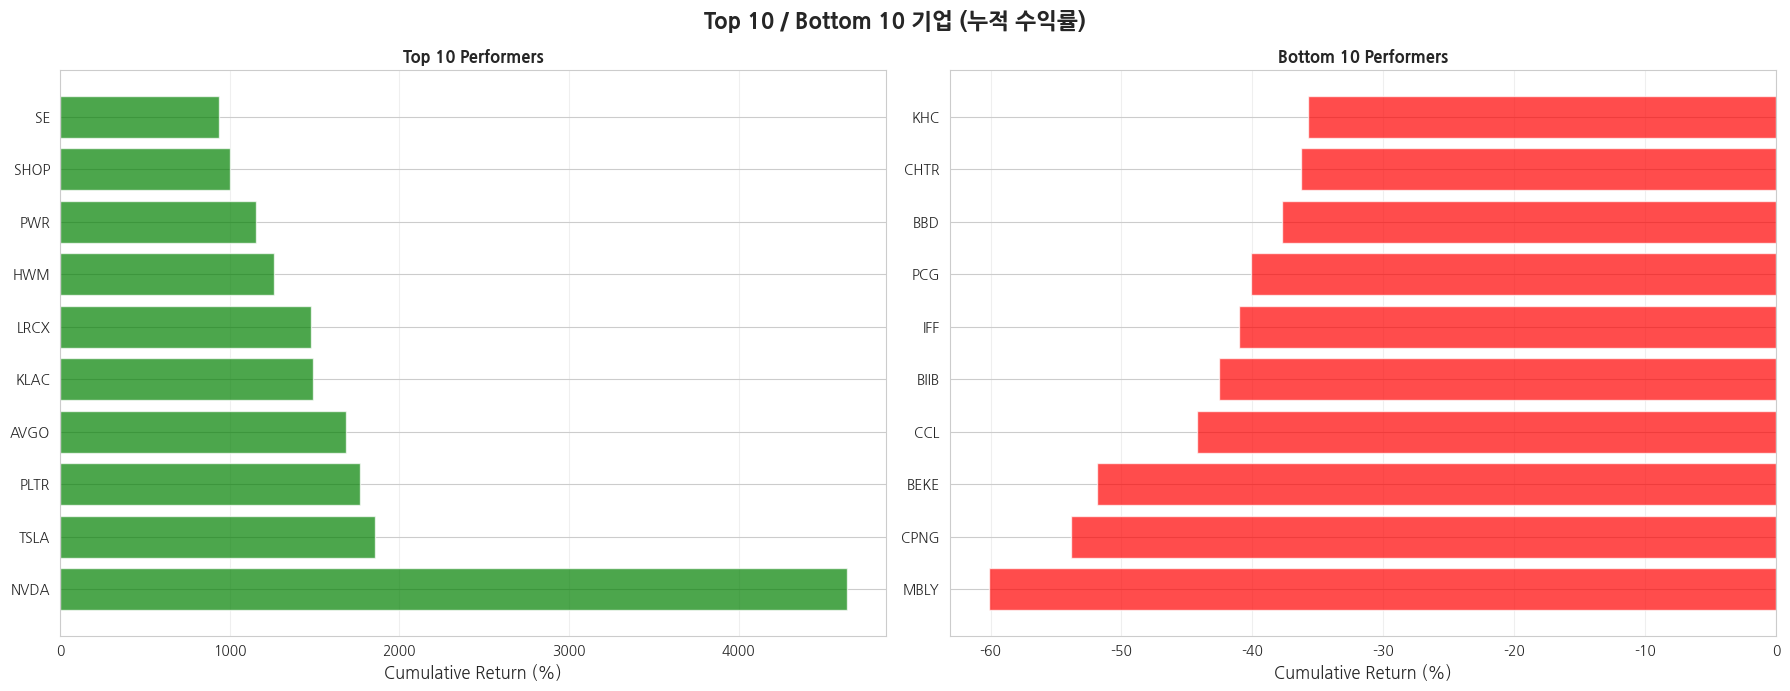

In [17]:
# 기업별 누적 수익률
company_cumret = df.groupby('Company').agg({
    'Cum_Return': 'last',
    'Volatility_20d': 'mean',
    'Sector': 'first',
    'MDD': 'min'
}).reset_index()

company_cumret = company_cumret.dropna()

# Top 10 / Bottom 10
top10 = company_cumret.nlargest(10, 'Cum_Return')
bottom10 = company_cumret.nsmallest(10, 'Cum_Return')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Top 10 / Bottom 10 기업 (누적 수익률)', fontsize=16, fontweight='bold')

axes[0].barh(top10['Company'], top10['Cum_Return'] * 100, color='green', alpha=0.7)
axes[0].set_xlabel('Cumulative Return (%)', fontsize=12)
axes[0].set_title('Top 10 Performers', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(bottom10['Company'], bottom10['Cum_Return'] * 100, color='red', alpha=0.7)
axes[1].set_xlabel('Cumulative Return (%)', fontsize=12)
axes[1].set_title('Bottom 10 Performers', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(VIZ_DIR / '09_top_bottom_performers.png', dpi=300, bbox_inches='tight')
plt.show()

# Tableau용 저장
performers = pd.concat([top10, bottom10], ignore_index=True)
performers.to_csv(TABLEAU_DIR / 'top_bottom_performers.csv', index=False)

### 5.3 Risk-Return Quadrant

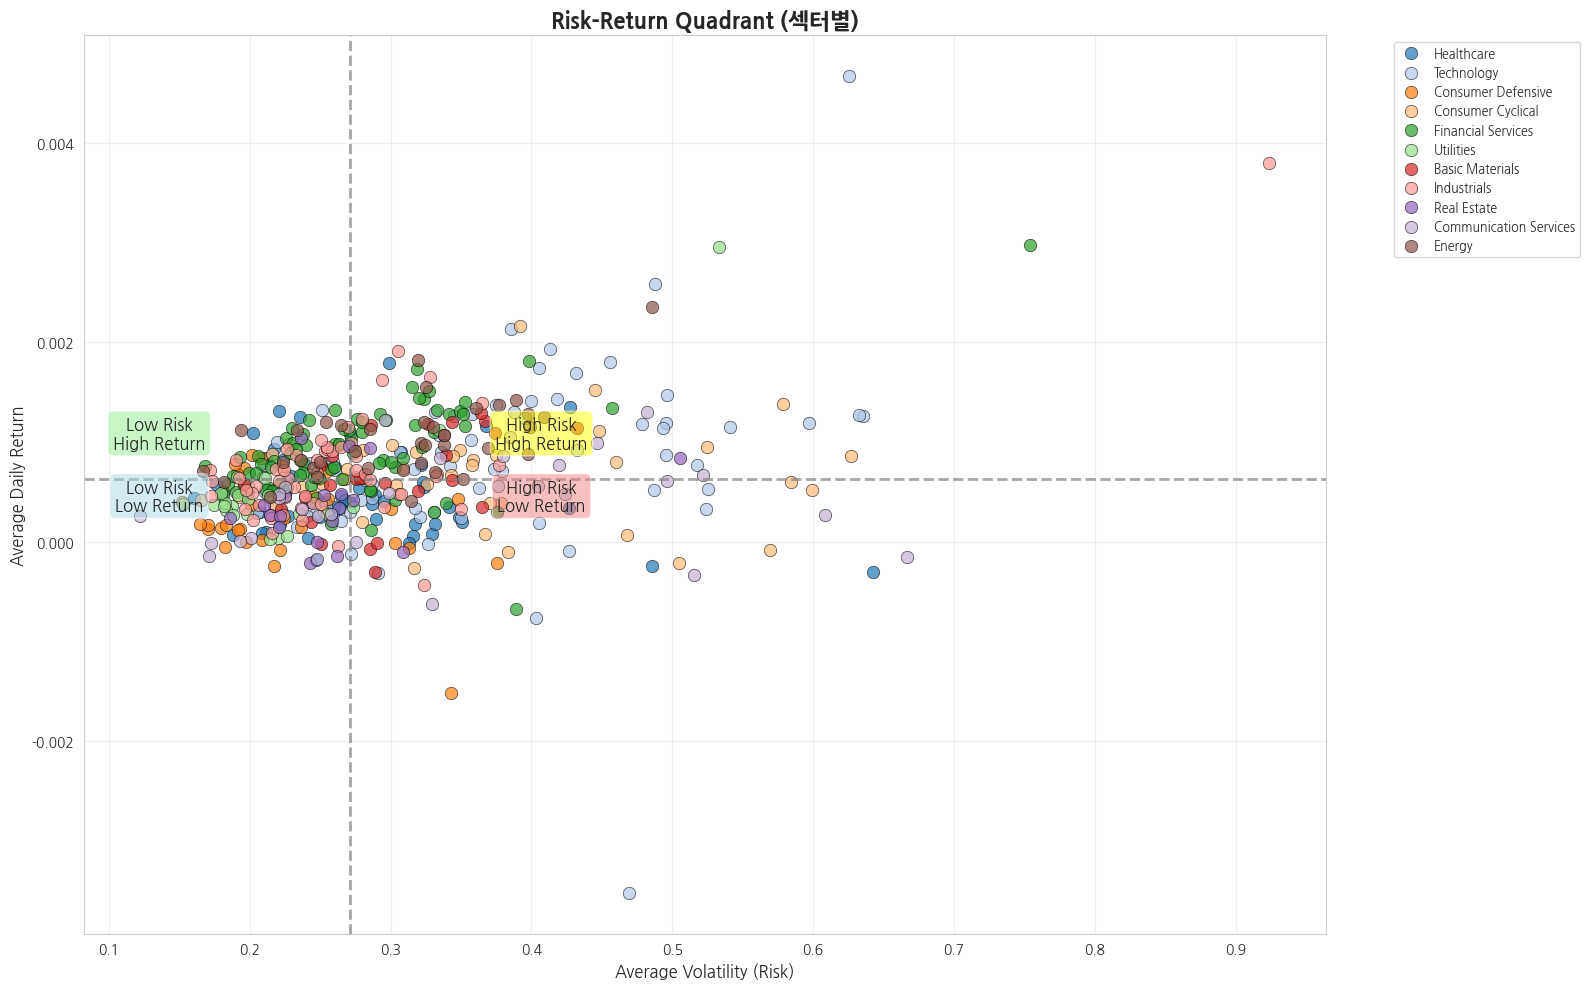

In [18]:
# 기업별 평균
company_risk_return = df.groupby('Company').agg({
    'Daily_Return_raw': 'mean',
    'Volatility_20d': 'mean',
    'Sector': 'first'
}).reset_index()

company_risk_return.columns = ['Company', 'Avg_Return', 'Avg_Volatility', 'Sector']
company_risk_return = company_risk_return.dropna()

# 산점도 (섹터별)
plt.figure(figsize=(16, 10))
sectors_unique = company_risk_return['Sector'].unique()
colors = sns.color_palette('tab20', len(sectors_unique))

for sector, color in zip(sectors_unique, colors):
    sector_data = company_risk_return[company_risk_return['Sector'] == sector]
    plt.scatter(sector_data['Avg_Volatility'], sector_data['Avg_Return'], 
                label=sector, alpha=0.7, s=80, color=color, edgecolors='black', linewidth=0.5)

# 사분면
median_return = company_risk_return['Avg_Return'].median()
median_vol = company_risk_return['Avg_Volatility'].median()

plt.axhline(median_return, color='gray', linestyle='--', linewidth=2, alpha=0.7)
plt.axvline(median_vol, color='gray', linestyle='--', linewidth=2, alpha=0.7)

# 사분면 라벨
plt.text(median_vol * 0.5, median_return * 1.5, 'Low Risk\nHigh Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
plt.text(median_vol * 1.5, median_return * 1.5, 'High Risk\nHigh Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
plt.text(median_vol * 0.5, median_return * 0.5, 'Low Risk\nLow Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
plt.text(median_vol * 1.5, median_return * 0.5, 'High Risk\nLow Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.title('Risk-Return Quadrant (섹터별)', fontsize=16, fontweight='bold')
plt.xlabel('Average Volatility (Risk)', fontsize=12)
plt.ylabel('Average Daily Return', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(VIZ_DIR / '10_risk_return_quadrant.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Section 6. 투자 인사이트 요약

In [19]:
# 핵심 인사이트 추출
print("=" * 70)
print("투자 인사이트 요약")
print("=" * 70)

# 1. 섹터 성과 순위
sector_performance = df.groupby('Sector')['Daily_Return_raw'].mean().sort_values(ascending=False)
print("\n[1] 섹터 평균 수익률 (Top 5):")
for i, (sector, ret) in enumerate(sector_performance.head(5).items(), 1):
    print(f"  {i}. {sector}: {ret*100:.4f}%")

# 2. 저변동성 고수익 기업
low_vol_high_ret = company_risk_return[
    (company_risk_return['Avg_Return'] > median_return) & 
    (company_risk_return['Avg_Volatility'] < median_vol)
].sort_values('Avg_Return', ascending=False).head(5)

print("\n[2] Top 5 Picks (저변동성 고수익):")
for i, row in enumerate(low_vol_high_ret.itertuples(), 1):
    print(f"  {i}. {row.Company} ({row.Sector})")
    print(f"     - 평균 수익률: {row.Avg_Return*100:.4f}%")
    print(f"     - 평균 변동성: {row.Avg_Volatility*100:.2f}%")

# 3. 고위험 고수익 기업
high_risk_high_ret = company_risk_return[
    (company_risk_return['Avg_Return'] > median_return) & 
    (company_risk_return['Avg_Volatility'] > median_vol)
].sort_values('Avg_Return', ascending=False).head(5)

print("\n[3] 공격적 투자 후보 (고위험 고수익):")
for i, row in enumerate(high_risk_high_ret.itertuples(), 1):
    print(f"  {i}. {row.Company} ({row.Sector})")
    print(f"     - 평균 수익률: {row.Avg_Return*100:.4f}%")
    print(f"     - 평균 변동성: {row.Avg_Volatility*100:.2f}%")

print("\n" + "=" * 70)

투자 인사이트 요약

[1] 섹터 평균 수익률 (Top 5):
  1. Energy: 0.1026%
  2. Financial Services: 0.0867%
  3. Technology: 0.0827%
  4. Industrials: 0.0701%
  5. Consumer Cyclical: 0.0637%

[2] Top 5 Picks (저변동성 고수익):
  1. GS (Financial Services)
     - 평균 수익률: 0.1318%
     - 평균 변동성: 26.06%
  2. APH (Technology)
     - 평균 수익률: 0.1316%
     - 평균 변동성: 25.14%
  3. MCK (Healthcare)
     - 평균 수익률: 0.1308%
     - 평균 변동성: 22.06%
  4. CAH (Healthcare)
     - 평균 수익률: 0.1250%
     - 평균 변동성: 23.55%
  5. HSBC (Financial Services)
     - 평균 수익률: 0.1218%
     - 평균 변동성: 24.21%

[3] 공격적 투자 후보 (고위험 고수익):
  1. PLTR (Technology)
     - 평균 수익률: 0.4667%
     - 평균 변동성: 62.52%
  2. SYM (Industrials)
     - 평균 수익률: 0.3795%
     - 평균 변동성: 92.38%
  3. COIN (Financial Services)
     - 평균 수익률: 0.2974%
     - 평균 변동성: 75.39%
  4. CEG (Utilities)
     - 평균 수익률: 0.2957%
     - 평균 변동성: 53.31%
  5. NVDA (Technology)
     - 평균 수익률: 0.2580%
     - 평균 변동성: 48.79%



In [20]:
# Tableau용 저장
low_vol_high_ret.to_csv(TABLEAU_DIR / 'top5_picks.csv', index=False)
high_risk_high_ret.to_csv(TABLEAU_DIR / 'aggressive_picks.csv', index=False)
print("\nTableau용 데이터 저장 완료")


Tableau용 데이터 저장 완료


In [21]:
# 생성된 파일 목록
print("\n" + "=" * 60)
print("생성된 시각화 파일")
print("=" * 60)

viz_files = list(VIZ_DIR.glob('*.png'))
for f in sorted(viz_files):
    print(f"  - {f.name}")

print(f"\n총 {len(viz_files)}개 시각화 파일 생성")

print("\n" + "=" * 60)
print("Tableau용 CSV 파일")
print("=" * 60)

tableau_files = list(TABLEAU_DIR.glob('*.csv'))
for f in sorted(tableau_files):
    print(f"  - {f.name}")

print(f"\n총 {len(tableau_files)}개 Tableau 파일 생성")
print("\n모든 EDA 작업 완료")


생성된 시각화 파일
  - 01_histogram.png
  - 02_boxplot_sector.png
  - 03_scatter_risk_return.png
  - 04_qqplot.png
  - 05_correlation_heatmap.png
  - 06_decomposition_AAPL.png
  - 07_acf_pacf_AAPL.png
  - 07_acf_pacf_Close_AAPL.png
  - 07_acf_pacf_Daily_Return_AAPL.png
  - 08_sector_performance_heatmap.png
  - 09_top_bottom_performers.png
  - 10_risk_return_quadrant.png

총 12개 시각화 파일 생성

Tableau용 CSV 파일
  - acf_pacf_AAPL.csv
  - acf_pacf_Close_AAPL.csv
  - acf_pacf_Daily_Return_AAPL.csv
  - acf_pacf_combined_AAPL.csv
  - acf_pacf_combined_TSLA.csv
  - acf_pacf_combined_TSLA_kch.csv
  - aggressive_picks.csv
  - aggressive_picks_kch.csv
  - correlation_matrix.csv
  - decomposition_AAPL.csv
  - decomposition_TSLA.csv
  - decomposition_TSLA_kch.csv
  - qqplot_data.csv
  - risk_return_scatter.csv
  - sector_monthly_performance.csv
  - sector_monthly_performance_kch.csv
  - top5_picks.csv
  - top5_picks_kch.csv
  - top_bottom_performers.csv
  - top_bottom_performers_kch.csv

총 20개 Tableau 파일 생성

모든